## HW Week 12 (#10) - Data fitting with various functions - Due Friday Nov 11, 2022

You will be using the same data "miniDR17.fits" from the TCU Online Week 11:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outlier!!!!  If you are not sure, ask!!!</b>). 

In [195]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

n = float("nan")

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    #print(a, b, c, d)
    #print(a*np.log(b*x + c) + d)
    #return a*np.log(b*x + c) + d
    #print(a*np.log(np.abs(b*x + c)) + d)
    return a*np.log(np.abs(b*x + c)) + d

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        #print(x_adj)
        #print(y_adj)
        #print(n in x_adj)
        #print(n in y_adj)
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISTIS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

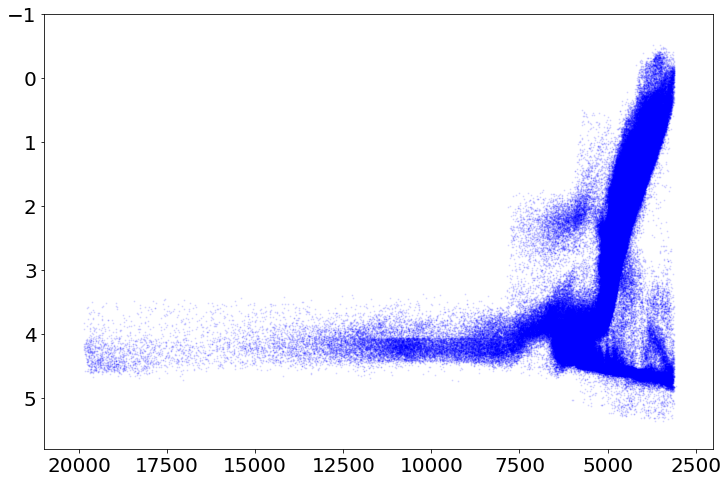

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 3

Fit a linear, polynomial (poly3), and a sigmoid functions and to the following selections of the data:<br>
3. Select stars only with with $GLAT > 60$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

LINEAR: 0.030, 0.019
POLY3: -0.042, -0.085, 0.006, 0.021
SIGMOID: -0.875, 24.257, 0.070, -0.055


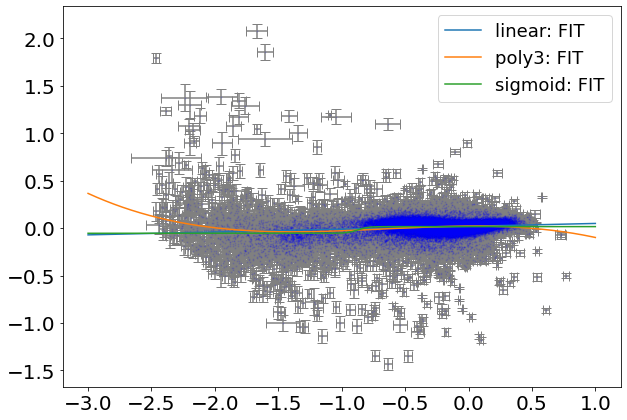

In [34]:
# write you fitting code and plot the results here
# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDE CUTS (e.g., −2 < GLAT < 2 )
starMod = star[~np.isnan(star['FE_H'])]
starMod = starMod[~np.isnan(starMod['NI_FE'])]
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0) &\
     (starMod['GLAT'] > 60)
cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, starMod['Fe_H'][cut1], starMod['NI_FE'][cut1], starMod['Fe_H_ERR'][cut1], \
                          starMod['NI_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, starMod['Fe_H'][cut1], starMod['NI_FE'][cut1], starMod['Fe_H_ERR'][cut1], \
                            starMod['NI_FE_ERR'][cut1],p0=[0,0,0,0])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

sigmA, sigmB, sigmC, sigmD = mcFit4(sigmoid, starMod['Fe_H'][cut1], starMod['NI_FE'][cut1], starMod['Fe_H_ERR'][cut1], \
                            starMod['NI_FE_ERR'][cut1],p0=[0,1,-1,0.5])
print(f'SIGMOID: {sigmA:.3f}, {sigmB:.3f}, {sigmC:.3f}, {sigmD:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(starMod['Fe_H'][cut1],starMod['NI_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['Fe_H'][cut1]),starMod['NI_FE'][cut1], xerr=(starMod['Fe_H_ERR'][cut1]),
             yerr=(starMod['NI_FE_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-3,1,1000) # X-PLOTING FOR FITS
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='poly3: FIT')
ax1.plot(x_plot,sigmoid(x_plot, sigmA, sigmB, sigmC, sigmD), label='sigmoid: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

In [4]:
#poly3 seems fits the data the best.
#There isn't a second population.

LINEAR: 0.030, 0.019


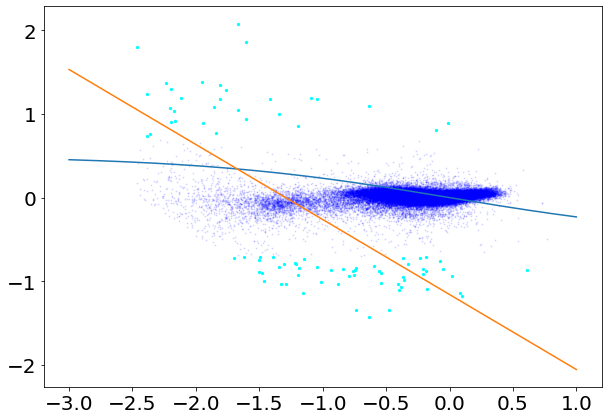

In [54]:
theta = (0, 1, -1, 0.5)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['Fe_H'][cut1],starMod['NI_FE'][cut1],s=1,c='b',alpha=0.1)
axTest.plot(x_plot,sigmoid(x_plot, *theta), label='sigmoid: FIT')

outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:<br>
4. Select stars only with with $GLAT < -10$  <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) with error of (np.sqrt(star['J\_ERR']\*\*2 + star['K\_ERR']\*\*2))__<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [144]:
# write you fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['TEFF'])]
starMod = starMod[~np.isnan(starMod['J'])]
starMod = starMod[~np.isnan(starMod['K'])]
starMod = starMod[~np.isnan(starMod['J_ERR'])]
starMod = starMod[~np.isnan(starMod['K_ERR'])]
#print(n in starMod['TEFF'])
#print(n in starMod['TEFF_ERR'])
#print(n in starMod['J'])
#print(n in starMod['K'])
#notInf = ~np.isinf(star['Fe_H'])
jMinusK = starMod['J'] - starMod['K']
#print(n in jMinusK)
jMinusKErr = np.sqrt(starMod['J_ERR'] ** 2 + starMod['K_ERR'] ** 2)
#print(n in jMinusKErr)
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0) &\
     (starMod['GLAT'] < -10)
cut1 = np.where(ct1)[0]
ct2 = (jMinusK[cut1] < 3) & (-0.00015 * starMod['TEFF'][cut1] + 0.9 - jMinusK[cut1] < 0)
cut2 = np.where(ct2)[0]

In [200]:
slope, intercept = mcFit2(linear, starMod['TEFF'][cut1][cut2], jMinusK[cut1][cut2], starMod['TEFF_ERR'][cut1][cut2], \
                          jMinusKErr[cut1][cut2], p0=[-0.0002,1.634])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

logA, logB, logC, logD = mcFit4(logfit, starMod['TEFF'][cut1][cut2], jMinusK[cut1][cut2], starMod['TEFF_ERR'][cut1][cut2], \
                            jMinusKErr[cut1][cut2],p0=[-0.718, 0.73, -1635.709, 6.085])
print(f'LOGFIT: {logA:.3f}, {logB:.3f}, {logC:.3f}, {logD:.3f}')

poly2A, poly2B, poly2C = mcFit3(poly2, starMod['TEFF'][cut1][cut2], jMinusK[cut1][cut2], starMod['TEFF_ERR'][cut1][cut2], \
                            jMinusKErr[cut1][cut2],p0=[0, -0.001, 2.632])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')

LINEAR: -0.000, 1.634
LOGFIT: -0.717, 0.759, -1702.607, 6.114
POLY2: 0.000, -0.001, 2.632


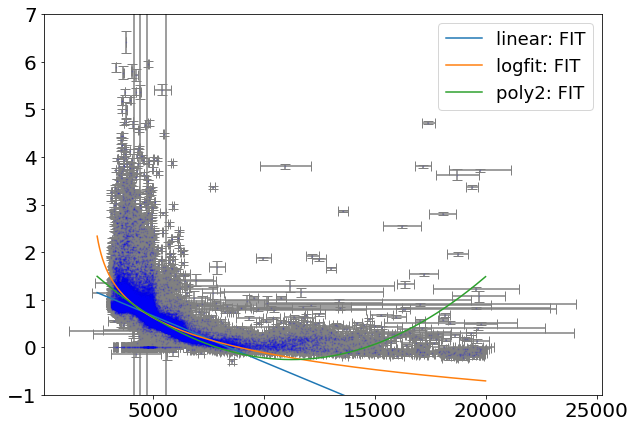

In [206]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['TEFF'][cut1],jMinusK[cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['TEFF'][cut1]),jMinusK[cut1], xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(jMinusKErr[cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax1.set_ylim(-1,7)
x_plot = np.linspace(2500,20000,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')
ax1.plot(x_plot,logfit(x_plot, logA, logB, logC, logD), label='logfit: FIT')
ax1.plot(x_plot,poly2(x_plot, poly2A, poly2B, poly2C), label='poly2: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

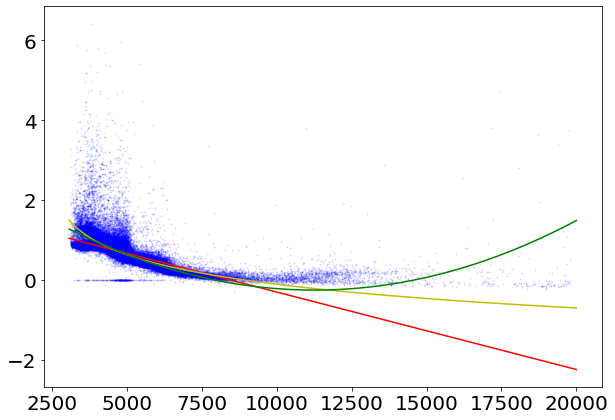

In [201]:
#theta = (-0.00015, 0.9)
theta = (slope, intercept)
#theta2 = (-0.3, 0.0000001, -0.0003, -2)
#theta2 = (-0.59, 0.0000000000000001, -0.0000000000003, -16.6)
#theta2 = (-0.5, 1, -3000, 4.5)
#theta2 = (-0.5, 1, -2300, 4.6)
#theta2 = (-0.5488, 0.9387, -2604, 4.8)
#-0.717, 0.732, -1638.391, 6.081
#-0.717, 0.705, -1574.517, 6.049
theta2 = (logA, logB, logC, logD)
#theta3 = (3*10**-9, 3*10**-9*2*-20000, 3*10**-9*20000**2)
theta3 = (poly2A, poly2B, poly2C)
#print(min(starMod['TEFF']))
#print(slope)
#print(poly2A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['TEFF'][cut1],jMinusK[cut1],s=1,c='b',alpha=0.1)
x_plot = np.linspace(3068,20000,1000)
axTest.plot(x_plot,linear(x_plot, *theta), color="r", label='linear: FIT')
axTest.plot(x_plot,logfit(x_plot, *theta2), color="y", label='logfit: FIT')
axTest.plot(x_plot,poly2(x_plot, *theta3), color="g", label='poly2: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [207]:
#logfit was modified
#poly3 best fits the data
#There is a second population

# DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:<br>
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [133]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['GLON'])]
starMod = starMod[~np.isnan(starMod['VHELIO_AVG'])]
starMod = starMod[starMod['VERR'] < 5000]
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0) &\
     (starMod['GLAT'] > -10) & (starMod['GLAT'] < 10)
cut1 = np.where(ct1)[0]
ct2 = (starMod['VHELIO_AVG'][cut1] < 550) & (starMod['VHELIO_AVG'][cut1] > -550)
cut2 = np.where(ct2)[0]

In [134]:
# write you fitting code and plot the results here
slope, intercept = mcFit2(linear, starMod['GLON'][cut1][cut2], starMod['VHELIO_AVG'][cut1][cut2], 0, \
                          starMod['VERR'][cut1][cut2], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, starMod['GLON'][cut1][cut2], starMod['VHELIO_AVG'][cut1][cut2], 0, \
                            starMod['VERR'][cut1][cut2],p0=[0,0.014,-1.781,27.971])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

cosA, cosB, cosC, cosD = mcFit4(cosfit, starMod['GLON'][cut1][cut2], starMod['VHELIO_AVG'][cut1][cut2], 0, \
                            starMod['VERR'][cut1][cut2],p0=[49.81,0.023,0.862,0.587])
print(f'COSFIT: {cosA:.3f}, {cosB:.3f}, {cosC:.3f}, {cosD:.3f}')

LINEAR: 0.004, -5.108
POLY3: -0.000, 0.015, -1.852, 28.582
COSFIT: 51.646, 0.022, 0.893, 0.548


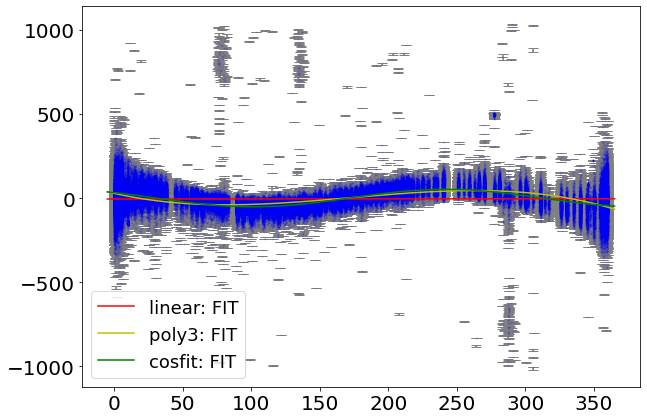

In [135]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['GLON'][cut1],starMod['VHELIO_AVG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['GLON'][cut1]),starMod['VHELIO_AVG'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


x_plot = np.linspace(-5,365,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), color="r", label='linear: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), color="y", label='poly3: FIT')
ax1.plot(x_plot,cosfit(x_plot, cosA, cosB, cosC, cosD), color="g", label='cosfit: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

-2.7599519310568612e-05


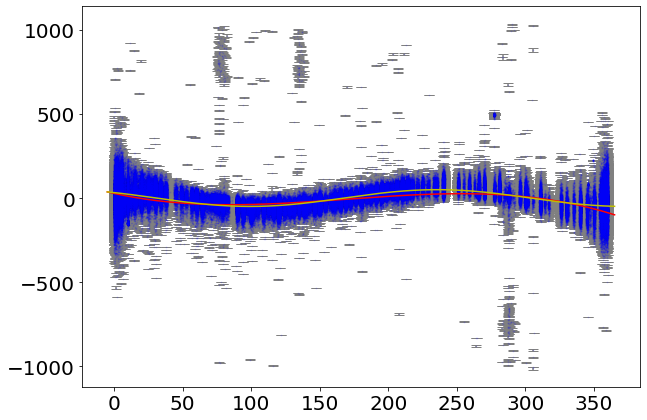

In [128]:
theta = (-2.7599519310568612e-05, 0.014, -1.781, 27.971)
#theta2 = (100, 0.025, 0, 0)
theta2 = (49.81, 0.023, 0.862, 0.587)
#print(min(starMod['TEFF']))
#print(max(starMod['VERR']))
print(poly3A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['GLON'][cut1],starMod['VHELIO_AVG'][cut1],s=1,c='b',alpha=0.1)
axTest.errorbar((starMod['GLON'][cut1]),starMod['VHELIO_AVG'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)
#axTest.set_ylim(-1100,1100)
#axTest.set_ylim(-1000000,1000000)
x_plot = np.linspace(-5,365,1000)
axTest.plot(x_plot,poly3(x_plot, *theta), color="red", label='poly3: FIT')
axTest.plot(x_plot,cosfit(x_plot, *theta2), color="y", label='cosfit: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [136]:
#cosfit best fits the data
#There isn't a second population

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:<br>
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [8]:
# write you fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['NVISTIS'])]
starMod = starMod[~np.isnan(starMod['VSCATTER'])]
starMod = starMod[starMod['VERR'] < 5000]
NV = starMod['NVISTIS']
NV = NV.astype('float64')
VS = starMod['VSCATTER']
VS = VS.astype('float64')
VE = starMod['VERR']
VE = VE.astype('float64')
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0) &\
     (starMod['NVISTIS'] >= 1)
cut1 = np.where(ct1)[0]
ct2 = (starMod['VSCATTER'][cut1] < 200)
cut2 = np.where(ct2)[0]

In [9]:
slope, intercept = mcFit2(linear, NV[cut1][cut2], VS[cut1][cut2], 0, \
                          VE[cut1][cut2], p0=[0.107,0.453])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, NV[cut1][cut2], VS[cut1][cut2], 0, \
                            VE[cut1][cut2],p0=[0.0003,-0.019,0.381,-0.112])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

expA, expB, expC, expD = mcFit4(exponential, NV[cut1][cut2], VS[cut1][cut2], 0, \
                            VE[cut1][cut2],p0=[8,-0.1,2,10])
print(f'EXPONENTIAL: {expA:.3f}, {expB:.3f}, {expC:.3f}, {expD:.3f}')

LINEAR: 0.107, 0.391
POLY3: 0.000, -0.018, 0.364, -0.139


C:\Users\natha\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


EXPONENTIAL: 1285.526, -0.095, -158.718, 0.768


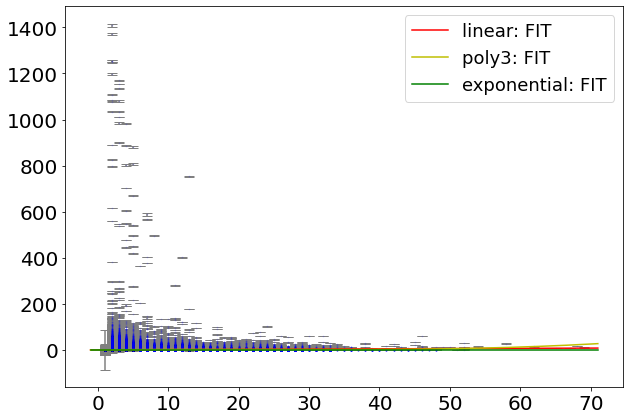

In [13]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['NVISTIS'][cut1],starMod['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['NVISTIS'][cut1]),starMod['VSCATTER'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


x_plot = np.linspace(-1,71,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), color="r", label='linear: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), color="y", label='poly3: FIT')
ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), color="g", label='exponential: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

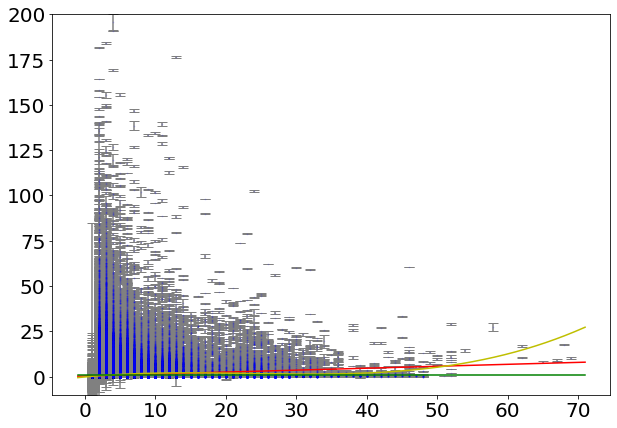

In [11]:
theta = (slope, intercept)
theta2 = (poly3A, poly3B, poly3C, poly3D)
theta3 = (expA, expB, expC, expD)
#theta2 = (8, -0.1, 2, 10)
#theta2 = (1, -0.05, 4.5, 0)
#print(min(starMod['TEFF']))
#print(max(starMod['VERR']))
#print(poly3A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['NVISTIS'][cut1],starMod['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
axTest.errorbar((starMod['NVISTIS'][cut1]),starMod['VSCATTER'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['VERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)
axTest.set_ylim(-10,200)
#axTest.set_ylim(-1000000,1000000)
x_plot = np.linspace(-1,71,1000)
axTest.plot(x_plot,linear(x_plot, *theta), color="r", label='linear: FIT')
axTest.plot(x_plot,poly3(x_plot, *theta2), color="y", label='poly3: FIT')
axTest.plot(x_plot,exponential(x_plot, *theta3), color="g", label='exponential: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [ ]:
#exponential best fits the data
#there isn't a second population

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:<br>
7. __Fit RA  vs.  GAIA_PMRA (GAIA_PMRA_ERROR)__<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [26]:
# write you fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['RA'])]
starMod = starMod[~np.isnan(starMod['GAIA_PMRA'])]
#starMod = starMod[starMod['VERR'] < 5000]
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0)# &\
     #(starMod['NVISTIS'] >= 1)
cut1 = np.where(ct1)[0]

In [28]:
slope, intercept = mcFit2(linear, starMod['RA'][cut1], starMod['GAIA_PMRA'][cut1], 0, \
                          starMod['GAIA_PMRA_ERROR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly2A, poly2B, poly2C = mcFit3(poly2, starMod['RA'][cut1], starMod['GAIA_PMRA'][cut1], 0, \
                            starMod['GAIA_PMRA_ERROR'][cut1],p0=[0,0,0])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, starMod['RA'][cut1], starMod['GAIA_PMRA'][cut1], 0, \
                            starMod['GAIA_PMRA_ERROR'][cut1],p0=[0,0.014,-1.781,27.971])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

LINEAR: -0.019, 0.602
POLY2: 0.001, -0.275, 16.747
POLY3: 0.000, -0.000, -0.169, 13.114


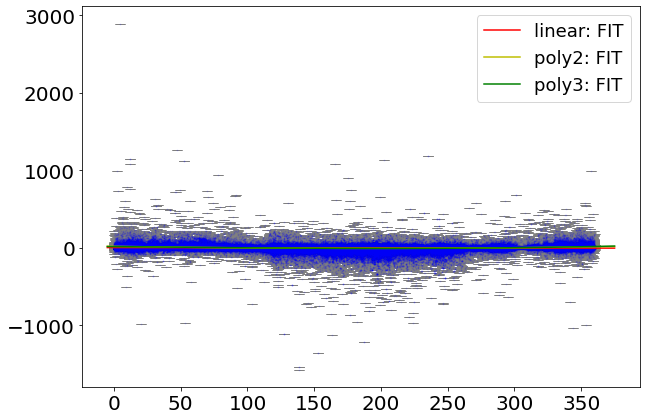

In [29]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['RA'][cut1],starMod['GAIA_PMRA'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['RA'][cut1]),starMod['GAIA_PMRA'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['GAIA_PMRA_ERROR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


x_plot = np.linspace(-5,375,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), color="r", label='linear: FIT')
ax1.plot(x_plot,poly2(x_plot, poly2A, poly2B, poly2C), color="y", label='poly2: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), color="g", label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

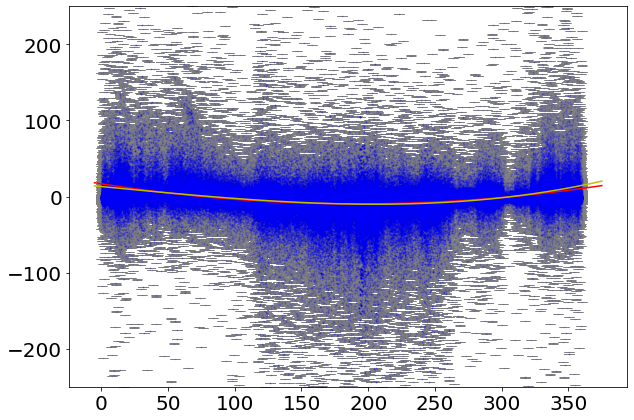

In [31]:
theta = (poly2A, poly2B, poly2C)
#theta2 = (100, 0.025, 0, 0)
theta2 = (poly3A, poly3B, poly3C, poly3D)
#print(min(starMod['TEFF']))
#print(max(starMod['VERR']))
#print(poly3A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['RA'][cut1],starMod['GAIA_PMRA'][cut1],s=1,c='b',alpha=0.1)
axTest.errorbar((starMod['RA'][cut1]),starMod['GAIA_PMRA'][cut1], #xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['GAIA_PMRA_ERROR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)
axTest.set_ylim(-250,250)
#axTest.set_ylim(-1000000,1000000)
x_plot = np.linspace(-5,375,1000)
axTest.plot(x_plot,poly2(x_plot, *theta), color="red", label='poly2: FIT')
axTest.plot(x_plot,poly3(x_plot, *theta2), color="y", label='poly3: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [32]:
#poly2 fits the data best
#There isn't a second population

## DATA FIT 8

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:<br>
8. select stars with only TEFF < 6000 and LOGG < 3<br>
__Fit TEFF (TEFF_ERR)  vs.  LOGG (LOGG_ERR)__<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [10]:
# write you fitting code and plot the results here
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['TEFF'])]
starMod = starMod[~np.isnan(starMod['LOGG'])]
#starMod = starMod[starMod['VERR'] < 5000]
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0) &\
     (starMod['TEFF'] < 6000) & (starMod['LOGG'] < 3)
cut1 = np.where(ct1)[0]
ct2 = (0.0035 * starMod['TEFF'][cut1] - 17 - starMod['LOGG'][cut1] < 0)
cut2 = np.where(ct2)[0]

In [11]:
slope, intercept = mcFit2(linear, starMod['TEFF'][cut1][cut2], starMod['LOGG'][cut1][cut2], \
                          starMod['TEFF_ERR'][cut1][cut2], starMod['LOGG_ERR'][cut1][cut2], p0=[0.001,-4.33])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly2A, poly2B, poly2C = mcFit3(poly2, starMod['TEFF'][cut1][cut2], starMod['LOGG'][cut1][cut2], \
                                starMod['TEFF_ERR'][cut1][cut2], starMod['LOGG_ERR'][cut1][cut2],\
                                p0=[0.0000007, 0.0000007*2*-2800, 0.0000007*2800 ** 2])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, starMod['TEFF'][cut1][cut2], starMod['LOGG'][cut1][cut2], \
                                        starMod['TEFF_ERR'][cut1][cut2], starMod['LOGG_ERR'][cut1][cut2],\
                                        p0=[10**-10, 10**-10*3*-1800, 10**-10*3*1800**2, 10**-10*-1800**3])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

LINEAR: 0.001, -4.663
POLY2: -0.000, 0.004, -9.543
POLY3: -0.000, 0.000, -0.044, 57.555


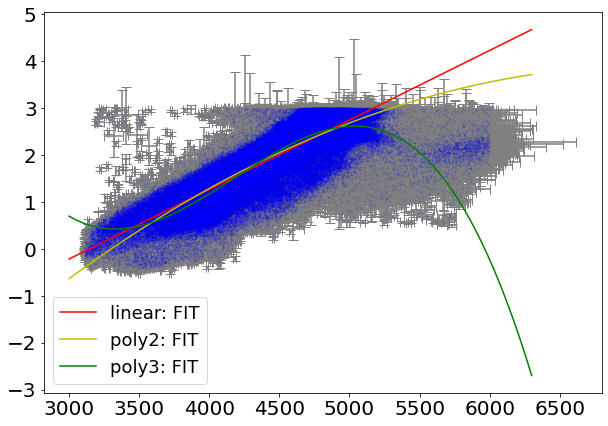

In [12]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['TEFF'][cut1],starMod['LOGG'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['TEFF'][cut1]),starMod['LOGG'][cut1], xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['LOGG_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


x_plot = np.linspace(3000,6300,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), color="r", label='linear: FIT')
ax1.plot(x_plot,poly2(x_plot, poly2A, poly2B, poly2C), color="y", label='poly2: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), color="g", label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

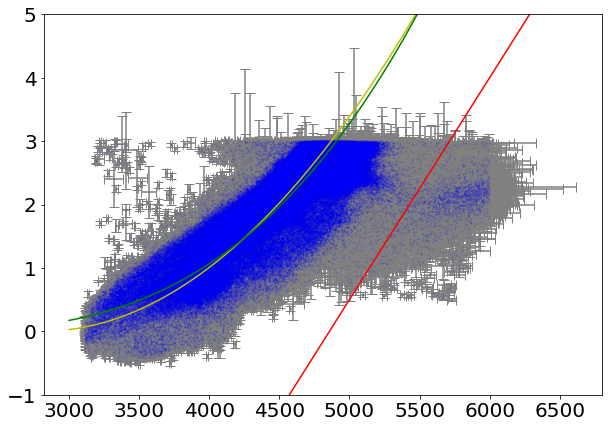

In [9]:
theta = (0.0035, -17)
theta2 = (0.0000007, 0.0000007*2*-2800, 0.0000007*2800 ** 2)
#theta2 = (100, 0.025, 0, 0)
theta3 = (1*10**-10, 1*10**-10*3*-1800, 1*10**-10*3*1800**2, 1*10**-10*-1800**3)
#print(min(starMod['TEFF']))
#print(max(starMod['VERR']))
#print(poly3A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['TEFF'][cut1],starMod['LOGG'][cut1],s=1,c='b',alpha=0.1)
axTest.errorbar((starMod['TEFF'][cut1]),starMod['LOGG'][cut1], xerr=(starMod['TEFF_ERR'][cut1]),
             yerr=(starMod['LOGG_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)
axTest.set_ylim(-1,5)
#axTest.set_ylim(-1000000,1000000)
x_plot = np.linspace(3000,6300,1000)
axTest.plot(x_plot,linear(x_plot, *theta), color="r", label='linear: FIT')
axTest.plot(x_plot,poly2(x_plot, *theta2), color="y", label='poly2: FIT')
axTest.plot(x_plot,poly3(x_plot, *theta3), color="g", label='poly3: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [13]:
#linear fits the data best
#There is a second population

## DATA FIT 9

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:<br>
9. __Fit GAIA_PARALLAX (GAIA_PARALLAX_ERROR) vs.  GAIA_PMRA (GAIA_PMRA_ERROR)__<br>
<br>
For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

In [19]:
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

starMod = star[~np.isnan(star['GAIA_PARALLAX'])]
starMod = starMod[~np.isnan(starMod['GAIA_PMRA'])]
#starMod = starMod[starMod['VERR'] < 5000]
#notInf = ~np.isinf(star['Fe_H'])
ct1 = (np.bitwise_and(starMod['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(starMod['starflag'], suspectbits) == 0)# &\
     #(starMod['NVISTIS'] >= 1)
cut1 = np.where(ct1)[0]

In [21]:
slope, intercept = mcFit2(linear, starMod['GAIA_PARALLAX'][cut1], starMod['GAIA_PMRA'][cut1], \
                          starMod['GAIA_PARALLAX_ERROR'][cut1], starMod['GAIA_PMRA_ERROR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

poly2A, poly2B, poly2C = mcFit3(poly2, starMod['GAIA_PARALLAX'][cut1], starMod['GAIA_PMRA'][cut1], \
                                starMod['GAIA_PARALLAX_ERROR'][cut1], starMod['GAIA_PMRA_ERROR'][cut1],p0=[0,0,0])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')

poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, starMod['GAIA_PARALLAX'][cut1], starMod['GAIA_PMRA'][cut1], \
                                        starMod['GAIA_PARALLAX_ERROR'][cut1], starMod['GAIA_PMRA_ERROR'][cut1],\
                                        p0=[0,0,0,0])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')

LINEAR: -0.985, -0.972
POLY2: 0.002, -1.100, -0.783
POLY3: -0.000, 0.009, -1.240, -0.601


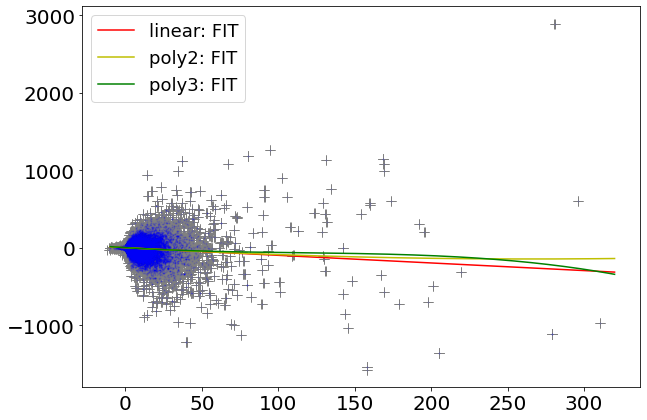

In [22]:
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(starMod['GAIA_PARALLAX'][cut1],starMod['GAIA_PMRA'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((starMod['GAIA_PARALLAX'][cut1]),starMod['GAIA_PMRA'][cut1], xerr=(starMod['GAIA_PARALLAX_ERROR'][cut1]),
             yerr=(starMod['GAIA_PMRA_ERROR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)


x_plot = np.linspace(-10,320,1000)
ax1.plot(x_plot,linear(x_plot, slope, intercept), color="r", label='linear: FIT')
ax1.plot(x_plot,poly2(x_plot, poly2A, poly2B, poly2C), color="y", label='poly2: FIT')
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), color="g", label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

-2.5944218122808966e-05


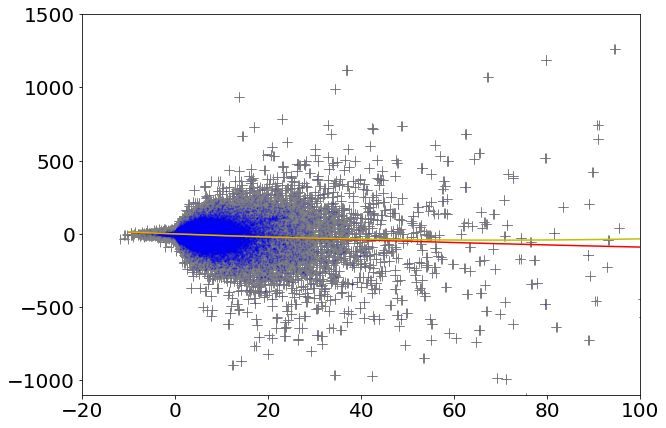

In [23]:
theta = (0.002, -1.1, -0.783)
#theta2 = (100, 0.025, 0, 0)
theta2 = (0, 0.009, -1.24, -0.601)
#print(min(starMod['TEFF']))
#print(max(starMod['VERR']))
print(poly3A)

figTest = plt.figure(figsize=(10,7))
axTest = figTest.add_subplot(111)
axTest.xaxis.set_tick_params(labelsize=20)
axTest.yaxis.set_tick_params(labelsize=20)
axTest.scatter(starMod['GAIA_PARALLAX'][cut1],starMod['GAIA_PMRA'][cut1],s=1,c='b',alpha=0.1)
axTest.errorbar((starMod['GAIA_PARALLAX'][cut1]),starMod['GAIA_PMRA'][cut1], xerr=(starMod['GAIA_PARALLAX_ERROR'][cut1]),
             yerr=(starMod['GAIA_PMRA_ERROR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)
axTest.set_xlim(-20,100)
axTest.set_ylim(-1100,1500)
#axTest.set_ylim(-1000000,1000000)
x_plot = np.linspace(-10,320,1000)
axTest.plot(x_plot,poly2(x_plot, *theta), color="red", label='poly2: FIT')
axTest.plot(x_plot,poly3(x_plot, *theta2), color="y", label='poly3: FIT')

#outlierTest = (starMod['NI_FE'][cut1] > 0.7) | (starMod['NI_FE'][cut1] < -0.7)
#axTest.scatter(starMod['Fe_H'][cut1][outlierTest],starMod['NI_FE'][cut1][outlierTest],s=5,c='cyan',facecolor='none')

#slopeTest, interceptTest = mcFit2(linear, starMod['Fe_H'][cut1][outlierTest], starMod['NI_FE'][cut1][outlierTest],\
#                          starMod['Fe_H_ERR'][cut1][outlierTest], starMod['NI_FE_ERR'][cut1][outlierTest], p0=[0,0])
#print(f'LINEAR: {slope:.3f}, {intercept:.3f}')
#axTest.plot(x_plot,linear(x_plot, slopeTest, interceptTest), label='linear: FIT')

In [24]:
#linear fits the data best
#There isn't a second population